# 0. Setup

In [4]:
import keras as keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers as optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import tensorflow as tf
import math
import os
from keras.models import load_model

In [19]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

# 1. Hyperparameters

In [8]:
input_height = 69
input_width = 69
input_depth = 3
batch_size = 64

# TODO: find best parameters using the display_data_augmentation_sample jupyter notebook
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=False

rotation_range=40
width_shift_range=0.2
height_shift_range=0.1
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

In [67]:
paths = {
    'CNN_DIR' : os.path.join('data','workspace','models', 'CNN_dropout_batch_bigger_class_weights.h5'),
    'VGG_DIR' : os.path.join('data','workspace','models', 'VGG16_finetuned.h5'),
    'TEST_PATH' : os.path.join('data','workspace','images', 'test')
 }

In [45]:
cnn = load_model(paths['CNN_DIR'],compile=False)
vgg = load_model(paths['VGG_DIR'],compile=False)

In [46]:
models = [cnn,vgg]

In [47]:
#rename model to prevent conflicts later
for i, layer in enumerate(cnn.layers):
    layer._name = layer._name + "_cnn"

cnn._name = cnn._name + "_cnn"

In [48]:
cnn.summary()

Model: "sequential_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_cnn (Conv2D)         (None, 69, 69, 16)        448       
                                                                 
 batch_normalization_cnn (Ba  (None, 69, 69, 16)       64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_cnn (MaxPooli  (None, 34, 34, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_1_cnn (Conv2D)       (None, 34, 34, 32)        4640      
                                                                 
 batch_normalization_1_cnn (  (None, 34, 34, 32)       128       
 BatchNormalization)                                             
                                                    

In [49]:
def ensamble(weight1 = 0.5, weight2 = 0.5):
    model_input = tf.keras.Input(shape=(input_width, input_height, input_depth))
    model_outputs = [model(model_input) for model in models]
    #if weights are equal, it's the same as calling keras.layers.Average()
    ensemble_output = WeightedAverageLayer(weight1,weight2)(model_outputs)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

    return ensemble_model


In [56]:
ensamble_model = ensamble(0.6,0.4)

ok


# 7. Model testing

In [75]:
from PIL import Image

In [76]:
from PIL import Image

number_test = 0
for i in range(9):
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

In [77]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

data/workspace/images/test
Found 2932 images belonging to 9 classes.


In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
Y_pred = ensamble_model.predict_generator(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4','5','6','7','8']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/var/folders/lg/pht1fcz51_l98v6k19cthpk40000gn/T/ipykernel_75407/475598227.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensamble_model.predict_generator(test_generator, number_test // batch_size+1)
2023-01-05 11:12:39.552705: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x15714b420>
Traceback (most recent call last):

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in ge

UnknownError: Graph execution error:

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x15714b420>
Traceback (most recent call last):

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/keras/utils/image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/opt/anaconda3/envs/GalaxyClassification/lib/python3.10/site-packages/PIL/Image.py", line 3186, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x15714b420>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_6033]

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_18366/2081199222.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, verbose = True)


92/92 [==============================] - 10s 105ms/step
Multiclass roc auc score: 0.8403849675200946


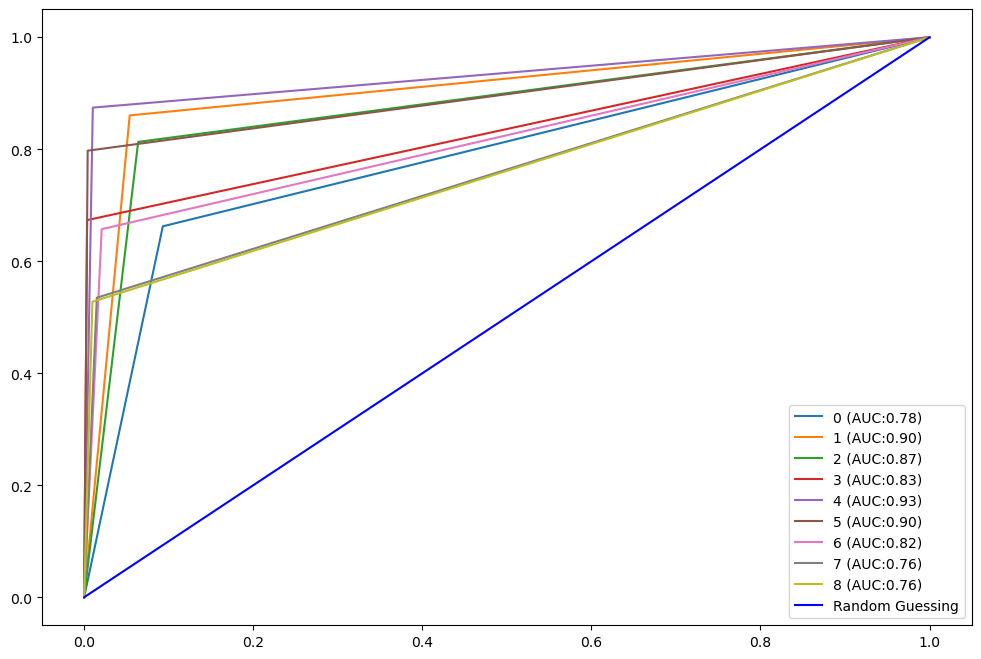

In [17]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = ensamble_model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 8. Model exportation

In [18]:
ensamble_model.save("data/workspace/models/ensamble_model.h5")

# 9. Plot model as graph of layers

In [58]:
from keras.utils import plot_model

In [59]:
plot_model(ensamble_model, show_shapes=True, to_file='model_ensamble.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
